In [47]:
import tensorflow as tf
# tf.enable_eager_execution()
tf.__version__

'2.8.2'

In [48]:
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

In [49]:
ds = tfds.load('fashion_mnist', split='train')

In [50]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255
ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(300)

In [51]:
def show(df):
  fig, ax = plt.subplots(ncols = 5, figsize = (10,10))
  for idx in range(5): 
      sample = df[idx]
      ax[idx].imshow(sample)
      ax[idx].title.set_text(idx)

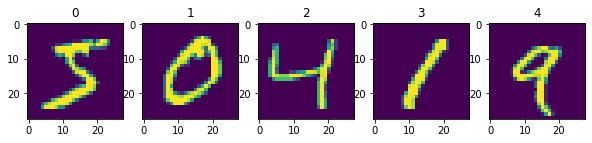

In [52]:
show(train_images)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D , BatchNormalization , Conv2DTranspose
import tensorflow as tf
def generator():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*100, use_bias=False,  input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 100)))
    assert model.output_shape == (None, 7, 7, 100)  # Note: None is the batch size

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [54]:
generator = generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4900)              490000    
                                                                 
 batch_normalization_6 (Batc  (None, 4900)             19600     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4900)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 100)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 64)         160000    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 64)        

In [55]:
generated_image = generator.predict(np.random.randn(5 , 100 , 1))

In [56]:
def show2(df):
  fig, ax = plt.subplots(ncols = 5, figsize = (10,10))
  for idx, img in enumerate(df): 
      ax[idx].imshow(np.squeeze(img)) 
      ax[idx].title.set_text(idx)

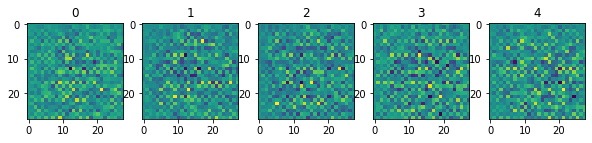

In [57]:
show2(generated_image)

In [58]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (3,3), padding='same',input_shape=[28, 28, 1]))
    model.add(LeakyReLU(0.3))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [59]:
discriminator = discriminator()
discriminator.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 28, 28, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)           

In [60]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[ 0.00037062]
 [-0.00490826]
 [-0.00291347]
 [-0.00014102]
 [-0.00507179]], shape=(5, 1), dtype=float32)


In [75]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

g_opt = tf.keras.optimizers.Adam(0.05)
d_opt = tf.keras.optimizers.Adam(0.05)

In [76]:
from tensorflow.keras.models import Model
class customized(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.loss = loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((1 , 100)), training = False)
        

        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training = True) 
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
    
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            total_d_loss = self.loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
 
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((1 , 100)), training = True)
            predicted_labels = self.discriminator(gen_images, training = False)
                                        
            total_g_loss = self.loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [77]:
fashgan = customized(generator, discriminator)

In [78]:
fashgan.compile(g_opt, d_opt, loss)

In [79]:
hist = fashgan.fit(ds, epochs = 30)

Epoch 1/30
200/200 [==============================] - 11s 47ms/step - d_loss: 2.5609e-12 - g_loss: 1.2974e-30
Epoch 2/30
200/200 [==============================] - 10s 48ms/step - d_loss: 7.2088e-13 - g_loss: 2.8113e-31
Epoch 3/30
200/200 [==============================] - 10s 48ms/step - d_loss: 2.3618e-13 - g_loss: 1.0618e-31
Epoch 4/30
200/200 [==============================] - 10s 48ms/step - d_loss: 1.5812e-13 - g_loss: 7.1583e-32
Epoch 5/30
200/200 [==============================] - 10s 47ms/step - d_loss: 1.1498e-13 - g_loss: 5.2287e-32
Epoch 6/30
200/200 [==============================] - 10s 49ms/step - d_loss: 8.7070e-14 - g_loss: 4.0817e-32
Epoch 7/30
200/200 [==============================] - 10s 47ms/step - d_loss: 7.0034e-14 - g_loss: 3.2190e-32
Epoch 8/30
200/200 [==============================] - 9s 47ms/step - d_loss: 6.4645e-14 - g_loss: 2.6117e-32
Epoch 9/30
200/200 [==============================] - 10s 48ms/step - d_loss: 5.0859e-14 - g_loss: 2.2477e-32
Epoch 10/30

In [82]:
imgs = generator.predict(np.random.randn(5 , 100 , 1))

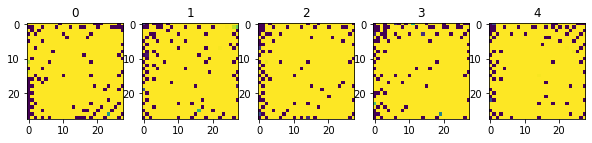

In [84]:
show2(imgs)